In [1]:
#Importing libraries
import pandas as pd
import random 
import numpy as np
import matplotlib.pyplot as plt 
from apyori import apyori
from kmodes.kprototypes import KPrototypes
from mlxtend.frequent_patterns import apriori, association_rules

%matplotlib inline 

### 1. Load data

In [3]:
#Load dataset
guns = pd.read_csv('gun-violence-data_01-2013_03-2018.csv')

<b>Dataset:</b> https://www.kaggle.com/code/amrish445/gunvoilence-explore/data 

In [3]:
#data
guns

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_age_group,participant_gender,participant_name,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||3::Male||4::Female,0::Julian Sims,NaN,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,NaN,NaN
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male,0::Bernard Gillis,NaN,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62.0,35.0
2,478855,2013-01-01,Ohio,Lorain,1776 East 28th Street,1,3,http://www.gunviolencearchive.org/incident/478855,http://chronicle.northcoastnow.com/2013/02/14/...,False,...,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Male||1::Male||2::Male||3::Male||4::Male,0::Damien Bell||1::Desmen Noble||2::Herman Sea...,NaN,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,http://www.morningjournal.com/general-news/201...,56.0,13.0
3,478925,2013-01-05,Colorado,Aurora,16000 block of East Ithaca Place,4,0,http://www.gunviolencearchive.org/incident/478925,http://www.dailydemocrat.com/20130106/aurora-s...,False,...,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Female||1::Male||2::Male||3::Male,0::Stacie Philbrook||1::Christopher Ratliffe||...,NaN,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://denver.cbslocal.com/2013/01/06/officer-...,40.0,28.0
4,478959,2013-01-07,North Carolina,Greensboro,307 Mourning Dove Terrace,2,2,http://www.gunviolencearchive.org/incident/478959,http://www.journalnow.com/news/local/article_d...,False,...,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Female||1::Male||2::Male||3::Female,0::Danielle Imani Jameison||1::Maurice Eugene ...,3::Family,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,http://myfox8.com/2013/01/08/update-mother-sho...,62.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,1083142,2018-03-31,Louisiana,Rayne,North Riceland Road and Highway 90,0,0,http://www.gunviolencearchive.org/incident/108...,http://www.klfy.com/news/local/rayne-woman-cha...,False,...,0::25,0::Adult 18+,0::Female,0::Jhkeya Tezeno,NaN,"0::Unharmed, Arrested",0::Subject-Suspect,http://www.klfy.com/news/local/rayne-woman-cha...,NaN,NaN
239673,1083139,2018-03-31,Louisiana,Natchitoches,247 Keyser Ave,1,0,http://www.gunviolencearchive.org/incident/108...,http://www.ksla.com/story/37854648/man-wanted-...,False,...,1::21,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Jamal Haskett||1::Jaquarious Tyjuan Ardison,NaN,"0::Killed||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,http://www.ksla.com/story/37854648/man-wanted-...,23.0,31.0
239674,1083151,2018-03-31,Louisiana,Gretna,1300 block of Cook Street,0,1,http://www.gunviolencearchive.org/incident/108...,http://www.nola.com/crime/index.ssf/2018/04/sh...,False,...,0::21,0::Adult 18+,0::Male,NaN,NaN,0::Injured,0::Victim,http://www.nola.com/crime/index.ssf/2018/04/sh...,85.0,7.0
239675,1082514,2018-03-31,Texas,Houston,12630 Ashford Point Dr,1,0,http://www.gunviolencearchive.org/incident/108...,https://www.ch

### 2. Data Cleaning

In [4]:
#Check null values
guns.isna().sum()

incident_id                         0
date                                0
state                               0
city_or_county                      0
address                         16497
n_killed                            0
n_injured                           0
incident_url                        0
source_url                        468
incident_url_fields_missing         0
congressional_district          11944
gun_stolen                      99498
gun_type                        99451
incident_characteristics          326
latitude                         7923
location_description           197588
longitude                        7923
n_guns_involved                 99451
notes                           81017
participant_age                 92298
participant_age_group           42119
participant_gender              36362
participant_name               122253
participant_relationship       223903
participant_status              27626
participant_type                24863
sources     

In [4]:
#Drop unnecessary columns
guns = guns.drop(['incident_id', 'incident_url', 'source_url', 'incident_url_fields_missing', 'participant_name', 'sources', 'latitude', 'longitude', 'notes', 'address', 'participant_gender', 'location_description', 'participant_relationship'], axis=1)

In [7]:
#Check data types
guns.dtypes

date                        datetime64[ns]
state                             category
city_or_county                    category
n_killed                             int64
n_injured                            int64
congressional_district            category
gun_stolen                          object
gun_type                            object
incident_characteristics            object
n_guns_involved                    float64
participant_age                     object
participant_age_group               object
participant_status                  object
participant_type                    object
state_house_district              category
state_senate_district             category
dtype: object

In [5]:
#Convert data types of relevant columns
guns['date'] = pd.to_datetime(guns['date'])
guns[['state', 'city_or_county', 'congressional_district', 'state_house_district', 'state_senate_district']] = guns[['state', 'city_or_county', 'congressional_district', 'state_house_district', 'state_senate_district']].astype('category')

In [6]:
#Rename columns for better viewing 
guns.rename(columns={'date':'Date', 'state':'State', 'city_or_county':'City/County', 'n_killed':'Kill Count', 'n_injured':'Injured Count', 'congressional_district':'Congress District', 'gun_type':'Gun Type', 'incident_characteristics':'Severity', 'n_guns_involved':'Gun Count', 'gun_stolen':'Stolen Gun?', 'state_house_district':'House District', 'state_senate_district':'Senate District'}, inplace=True)

In [9]:
#View df
guns

,Date,State,City/County,Kill Count,Injured Count,Congress District,Stolen Gun?,Gun Type,Severity,Gun Count,participant_age,participant_age_group,participant_status,participant_type,House District,Senate District
0,2013-01-01,Pennsylvania,Mckeesport,0,4,14.0,NaN,NaN,Shot - Wounded/Injured||Mass Shooting (4+ vict...,NaN,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,NaN,NaN
1,2013-01-01,California,Hawthorne,1,3,43.0,NaN,NaN,"Shot - Wounded/Injured||Shot - Dead (murder, a...",NaN,0::20,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,62.0,35.0
2,2013-01-01,Ohio,Lorain,1,3,9.0,0::Unknown||1::Unknown,0::Unknown||1::Unknown,"Shot - Wounded/Injured||Shot - Dead (murder, a...",2.0,0::25||1::31||2::33||3::34||4::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,"0::Injured, Unharmed, Arrested||1::Unharmed, A...",0::Subject-Suspect||1::Subject-Suspect||2::Vic...,56.0,13.0
3,2013-01-05,Colorado,Aurora,4,0,6.0,NaN,NaN,"Shot - Dead (murder, accidental, suicide)||Off...",NaN,0::29||1::33||2::56||3::33,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Killed||1::Killed||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,40.0,28.0
4,2013-01-07,North Carolina,Greensboro,2,2,6.0,0::Unknown||1::Unknown,0::Handgun||1::Handgun,"Shot - Wounded/Injured||Shot - Dead (murder, a...",2.0,0::18||1::46||2::14||3::47,0::Adult 18+||1::Adult 18+||2::Teen 12-17||3::...,0::Injured||1::Injured||2::Killed||3::Killed,0::Victim||1::Victim||2::Victim||3::Subject-Su...,62.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239672,2018-03-31,Louisiana,Rayne,0,0,NaN,0::Unknown,0::Unknown,Shots Fired - No Injuries,1.0,0::25,0::Adult 18+,"0::Unharmed, Arrested",0::Subject-Suspect,NaN,NaN
239673,2018-03-31,Louisiana,Natchitoches,1,0,4.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)||Ins...",1.0,1::21,0::Adult 18+||1::Adult 18+,"0::Killed||1::Unharmed, Arrested",0::Victim||1::Subject-Suspect,23.0,31.0
239674,2018-03-31,Louisiana,Gretna,0,1,2.0,0::Unknown,0::Unknown,Shot - Wounded/Injured,1.0,0::21,0::Adult 18+,0::Injured,0::Victim,85.0,7.0
239675,2018-03-31,Texas,Houston,1,0,9.0,0::Unknown,0::Unknown,"Shot - Dead (murder, accidental, suicide)",1.0,0::42,0::Adult 18+,0::Killed,0::Victim,149.0,17.0


### 3. Data Exploration

In [7]:
#View frequency of categories
guns['Stolen Gun?'].value_counts()

0::Unknown                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [8]:
#View frequency of categories
guns['Gun Type'].value_counts()

0::Unknown                                                                                                                                                                                                          93559
0::Handgun                                                                                                                                                                                                          13018
0::9mm                                                                                                                                                                                                               4599
0::Unknown||1::Unknown                                                                                                                                                                                               2410
0::22 LR                                                                                                                        

In [9]:
#View frequency of categories
guns['participant_age_group'].value_counts().head(20)

0::Adult 18+                                                                          94671
0::Adult 18+||1::Adult 18+                                                            49273
0::Adult 18+||1::Adult 18+||2::Adult 18+                                              13893
0::Teen 12-17                                                                          7392
0::Adult 18+||1::Adult 18+||2::Adult 18+||3::Adult 18+                                 4975
1::Adult 18+                                                                           3916
0::Adult 18+||1::Teen 12-17                                                            1962
0::Teen 12-17||1::Adult 18+                                                            1914
0::Adult 18+||1::Adult 18+||2::Adult 18+||3::Adult 18+||4::Adult 18+                   1736
0::Teen 12-17||1::Teen 12-17                                                           1673
0:Adult 18+                                                                     

In [10]:
#Replace common word occurences with single category
guns.loc[guns['participant_age_group']=="0::Adult 18+", 'Handled_age_group'] = 'Adult' 
guns.loc[guns['participant_age_group']=="0:Adult 18+", 'Handled_age_group'] = 'Adult' 
guns.loc[guns['participant_age_group']=="0:Adult 18+||1:Adult 18+", 'Handled_age_group'] = 'Adult' 
guns.loc[guns['participant_age_group']=="0::Adult 18+||1::Adult 18+", 'Handled_age_group'] = 'Adult' 
guns.loc[guns['participant_age_group']=="0:Adult 18+||1:Adult 18+||2:Adult 18+", 'Handled_age_group'] = 'Adult' 
guns.loc[guns['participant_age_group']=="0::Adult 18+||1::Adult 18+||2::Adult 18+", 'Handled_age_group'] = 'Adult' 
guns.loc[guns['participant_age_group']=="0::Adult 18+||1::Adult 18+||2::Adult 18+||3::Adult 18+", 'Handled_age_group'] = 'Adult' 
guns.loc[guns['participant_age_group']=="0::Teen 12-17", 'Handled_age_group'] = 'Teen'
guns.loc[guns['participant_age_group']=="0:Teen 12-17", 'Handled_age_group'] = 'Teen'
guns.loc[guns['participant_age_group']=="0::Child 0-11", 'Handled_age_group'] = 'Child' 
guns.loc[guns['participant_age_group']=="0:Child 0-11", 'Handled_age_group'] = 'Child'

In [11]:
#Check
guns['Handled_age_group'].value_counts()

Adult    164064
Teen       7464
Child      1101
Name: Handled_age_group, dtype: int64

In [12]:
#Replace remaining values with specified string
(guns['Handled_age_group']).fillna('Multiple_Age_Group', inplace=True)

In [13]:
#Check 
guns['Handled_age_group'].value_counts()

Adult                 164064
Multiple_Age_Group     67048
Teen                    7464
Child                   1101
Name: Handled_age_group, dtype: int64

In [17]:
#check top 20 values for category 
guns['participant_age_group'].value_counts().head(20)

0::Adult 18+                                                                          94671
0::Adult 18+||1::Adult 18+                                                            49273
0::Adult 18+||1::Adult 18+||2::Adult 18+                                              13893
0::Teen 12-17                                                                          7392
0::Adult 18+||1::Adult 18+||2::Adult 18+||3::Adult 18+                                 4975
1::Adult 18+                                                                           3916
0::Adult 18+||1::Teen 12-17                                                            1962
0::Teen 12-17||1::Adult 18+                                                            1914
0::Adult 18+||1::Adult 18+||2::Adult 18+||3::Adult 18+||4::Adult 18+                   1736
0::Teen 12-17||1::Teen 12-17                                                           1673
0:Adult 18+                                                                     

In [18]:
#check top 20 values for category 
guns['participant_type'].value_counts().head(20)

0::Victim                                                                                    58564
0::Victim||1::Subject-Suspect                                                                50579
0::Subject-Suspect                                                                           44914
0::Victim||1::Subject-Suspect||2::Subject-Suspect                                            10941
0::Victim||1::Victim                                                                          9033
0::Subject-Suspect||1::Subject-Suspect                                                        8922
0::Victim||1::Victim||2::Subject-Suspect                                                      6552
0::Victim||1::Subject-Suspect||2::Subject-Suspect||3::Subject-Suspect                         3720
0::Subject-Suspect||1::Subject-Suspect||2::Subject-Suspect                                    3040
0::Victim||1::Victim||2::Subject-Suspect||3::Subject-Suspect                                  2107
0::Victim|

In [14]:
#Using regex, replace common values with fixed categorical value
guns.loc[guns['participant_type']=="0::Victim", 'Handled_participant_type'] = 'Victim' 
guns.loc[guns['participant_type']=="0:Victim", 'Handled_participant_type'] = 'Victim'
guns.loc[guns['participant_type'].str.count(r'Victim.*?Victim')==1, 'Handled_participant_type'] = 'Victim' 
guns.loc[guns['participant_type'].str.count(r'Subject-Suspect.*?Subject-Suspect')==1, 'Handled_participant_type'] = 'Suspect'
guns.loc[guns['participant_type'].str.count(r'Subject-Suspect.*?Subject-Suspect*?Victim')==1, 'Handled_participant_type'] = 'Victim & Suspect'
guns.loc[guns['participant_type'].str.count(r'Victim.*?Suspect')==1, 'Handled_participant_type'] = 'Victim & Suspect' 
guns.loc[guns['participant_type']=="0::Subject-Suspect", 'Handled_participant_type'] = 'Suspect' 
guns.loc[guns['participant_type']=="0:Subject-Suspect", 'Handled_participant_type'] = 'Suspect' 

In [16]:
#Replace values with fixed categorical value
guns.loc[guns['Gun Type']=="0::9mm", 'Handled_gun_type'] = '9mm' 
guns.loc[guns['Gun Type']=="0:9mm", 'Handled_gun_type'] = '9mm' 
guns.loc[guns['Gun Type']=="0::Handgun", 'Handled_gun_type'] = 'Handgun' 
guns.loc[guns['Gun Type']=="0:Handgun", 'Handled_gun_type'] = 'Handgun' 
guns.loc[guns['Gun Type']=="0::Unknown", 'Handled_gun_type'] = 'Unknown' 
guns.loc[guns['Gun Type']=="0:Unknown", 'Handled_gun_type'] = 'Unknown' 

In [17]:
#Replace values with fixed categorical value
guns.loc[guns['Gun Type']=="0::9mm||1::9mm", 'Handled_gun_type'] = '9mm' 
guns.loc[guns['Gun Type']=="0::Handgun||1::Handgun", 'Handled_gun_type'] = 'Handgun' 
guns.loc[guns['Gun Type']=="0::Unknown||1::Unknown", 'Handled_gun_type'] = 'Handgun'
guns.loc[guns['Gun Type']=="0::Unknown||1::Unknown||2::Unknown", 'Handled_gun_type'] = 'Unknown'
guns.loc[guns['Gun Type']=="0::Unknown||1::Unknown||3::Unknown||4::Unknown", 'Handled_gun_type'] = 'Unknown'

In [18]:
#Replace remaining values with specified string
(guns['Handled_gun_type']).fillna('Multiple_Weapons', inplace=True)

In [23]:
#Check
guns['Handled_gun_type'].value_counts()

Multiple_Weapons    123662
Unknown              94406
Handgun              16904
9mm                   4705
Name: Handled_gun_type, dtype: int64

In [24]:
#Check frequent occurences in category
guns['Stolen Gun?'].value_counts()

0::Unknown                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [19]:
#Using regex, replace with fixed category
guns[guns['Stolen Gun?'].str.count(r'(^0*.::Stolen.*)')==1]

,Date,State,City/County,Kill Count,Injured Count,Congress District,Stolen Gun?,Gun Type,Severity,Gun Count,participant_age,participant_age_group,participant_status,participant_type,House District,Senate District,Handled_age_group,Handled_participant_type,Handled_gun_type
207,2013-09-24,West Virginia,Huntington,0,6,3.0,0::Stolen||1::Stolen,0::Handgun||1::Handgun,Shot - Wounded/Injured||Mass Shooting (4+ vict...,2.0,0::21||1::36||2::22||3::23||4::19||5::23||6::31,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,0::Injured||1::Injured||2::Injured||3::Injured...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,17.0,5.0,Multiple_Age_Group,Victim & Suspect,Handgun
1124,2014-01-07,Virginia,Ferrum,0,2,5.0,0::Stolen||1::Stolen,0::22 LR||1::Rifle,Shot - Wounded/Injured||Home Invasion||Officer...,2.0,1::31||2::34,0::Adult 18+||1::Adult 18+||2::Adult 18+,"0::Injured||1::Injured, Arrested||2::Unharmed,...",0::Victim||1::Subject-Suspect||2::Subject-Suspect,9.0,19.0,Adult,Victim & Suspect,Multiple_Weapons
1249,2014-01-08,New York,Lockport,0,0,27.0,0::Stolen,0::Shotgun,Non-Shooting Incident||Gun(s) stolen from owner,1.0,0::37,0::Adult 18+||1::Adult 18+,0::Unharmed||1::Unharmed,0::Subject-Suspect||1::Victim,144.0,62.0,Adult,NaN,Multiple_Weapons
2324,2014-01-15,Maryland,Suitland,0,1,4.0,0::Stolen||1::Stolen||2::Unknown||3::Unknown,0::Unknown||1::Unknown||2::Unknown||3::Unknown,Shots Fired - No Injuries||Armed robbery with ...,4.0,1::28||2::22||3::24||4::23,0::Adult 18+||1::Adult 18+||2::Adult 18+||3::A...,"0::Injured||1::Unharmed, Arrested||2::Unharmed...",0::Victim||1::Subject-Suspect||2::Subject-Susp...,26.0,26.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons
2625,2014-01-17,Illinois,Chicago,0,0,NaN,0::Stolen,0::40 SW,Non-Shooting Incident||Gang involvement||Gun(s...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Multiple_Age_Group,NaN,Multiple_Weapons
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239487,2018-03-30,North Carolina,Weldon,0,0,1.0,0::Stolen||1::Unknown||2::Unknown||3::Unknown|...,0::Unknown||1::Unknown||2::Unknown||3::Unknown...,Non-Shooting Incident||ATF/LE Confiscation/Rai...,5.0,0::60,0::Adult 18+,"0::Unharmed, Arrested",0::Subject-Suspect,27.0,4.0,Adult,Suspect,Multiple_Weapons
239533,2018-03-30,California,Manteca,0,0,10.0,0::Stolen,0::9mm,Non-Shooting Incident||Gang involvement||ATF/L...,1.0,0::26,0::Adult 18+,NaN,0::Subject-Suspect,12.0,5.0,Adult,Suspect,9mm
239540,2018-03-30,Colorado,Pueblo,0,0,NaN,0::Stolen||1::Stolen||2::Stolen||3::Stolen||4:...,0::357 Mag||1::44 Mag||2::45 Auto||3::Rifle||4...,Non-Shooting Incident||Gun(s) stolen from owner,8.0,NaN,NaN,NaN,NaN,NaN,NaN,Multiple_Age_Group,NaN,Multiple_Weapons
239547,2018-03-31,Ohio,Perrysburg,0,0,NaN,0::Stolen,0::Handgun,Non-Shooting Incident||Gun(s) stolen from owner,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Multiple_Age_Group,NaN,Handgun


In [20]:
#Using regex, replace with fixed category
guns.loc[guns['Stolen Gun?'].str.count(r'(^0*.::Stolen.*)')==1, 'Handled_Stolen'] = 'Stolen'
guns.loc[guns['Stolen Gun?'].str.count(r'(^0*.::Not-stolen.*)')==1, 'Handled_Stolen'] = 'Not-stolen'

In [21]:
#Replace remaining values with specified string
(guns['Handled_Stolen']).fillna('Unknown', inplace=True)

In [22]:
#Drop unnecessary columns
guns = guns.drop(['House District', 'Senate District', 'Congress District', 'Severity', 'participant_age_group', 'participant_status', 'participant_type', 'Stolen Gun?', 'Gun Type', 'participant_age'], axis=1)

In [29]:
guns

,Date,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen
0,2013-01-01,Pennsylvania,Mckeesport,0,4,NaN,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Unknown
1,2013-01-01,California,Hawthorne,1,3,NaN,Adult,Victim & Suspect,Multiple_Weapons,Unknown
2,2013-01-01,Ohio,Lorain,1,3,2.0,Multiple_Age_Group,Suspect,Handgun,Unknown
3,2013-01-05,Colorado,Aurora,4,0,NaN,Adult,Victim & Suspect,Multiple_Weapons,Unknown
4,2013-01-07,North Carolina,Greensboro,2,2,2.0,Multiple_Age_Group,Victim & Suspect,Handgun,Unknown
...,...,...,...,...,...,...,...,...,...,...
239672,2018-03-31,Louisiana,Rayne,0,0,1.0,Adult,Suspect,Unknown,Unknown
239673,2018-03-31,Louisiana,Natchitoches,1,0,1.0,Adult,Victim & Suspect,Unknown,Unknown
239674,2018-03-31,Louisiana,Gretna,0,1,1.0,Adult,Victim,Unknown,Unknown
239675,2018-03-31,Texas,Houston,1,0,1.0,Adult,Victim,Unknown,Unknown


In [23]:
#Drop rows with null values
guns = guns.dropna()

In [31]:
guns

,Date,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen
2,2013-01-01,Ohio,Lorain,1,3,2.0,Multiple_Age_Group,Suspect,Handgun,Unknown
4,2013-01-07,North Carolina,Greensboro,2,2,2.0,Multiple_Age_Group,Victim & Suspect,Handgun,Unknown
6,2013-01-19,New Mexico,Albuquerque,5,0,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Unknown
10,2013-01-23,Tennessee,Chattanooga,1,3,1.0,Adult,Victim & Suspect,Unknown,Unknown
11,2013-01-25,Missouri,Saint Louis,1,3,1.0,Adult,Victim & Suspect,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...
239672,2018-03-31,Louisiana,Rayne,0,0,1.0,Adult,Suspect,Unknown,Unknown
239673,2018-03-31,Louisiana,Natchitoches,1,0,1.0,Adult,Victim & Suspect,Unknown,Unknown
239674,2018-03-31,Louisiana,Gretna,0,1,1.0,Adult,Victim,Unknown,Unknown
239675,2018-03-31,Texas,Houston,1,0,1.0,Adult,Victim,Unknown,Unknown


In [24]:
guns['Handled_Stolen'].value_counts()

Unknown       116131
Stolen          5008
Not-stolen       988
Name: Handled_Stolen, dtype: int64

In [25]:
#Remove guns with category='Unknown'
guns = guns[guns['Handled_Stolen'] != 'Unknown']

In [26]:
#Check
guns['Handled_Stolen'].value_counts()

Stolen        5008
Not-stolen     988
Name: Handled_Stolen, dtype: int64

In [35]:
guns['Handled_gun_type'].value_counts()

Multiple_Weapons    2868
Handgun             1612
Unknown              950
9mm                  566
Name: Handled_gun_type, dtype: int64

In [27]:
#Remove guns with category='Unknown'
guns = guns[guns['Handled_gun_type'] != 'Unknown']

In [37]:
guns['Handled_gun_type'].value_counts()

Multiple_Weapons    2868
Handgun             1612
9mm                  566
Name: Handled_gun_type, dtype: int64

In [38]:
#Check shape of resultant dataset
guns.shape

(5046, 10)

In [39]:
#Make new df
guns2=guns 

In [28]:
#Drop date column
guns = guns.drop('Date', axis=1)

In [41]:
guns['Handled_participant_type'].value_counts()

Suspect             3749
Victim & Suspect     962
Victim               335
Name: Handled_participant_type, dtype: int64

In [42]:
#Check data types
guns.dtypes

State                       category
City/County                 category
Kill Count                     int64
Injured Count                  int64
Gun Count                    float64
Handled_age_group             object
Handled_participant_type      object
Handled_gun_type              object
Handled_Stolen                object
dtype: object

In [29]:
#Convert data type of specified columns to categorical
guns[['Handled_age_group','Handled_participant_type','Handled_gun_type','Handled_Stolen']]=guns[['Handled_age_group','Handled_participant_type','Handled_gun_type','Handled_Stolen']].astype('category')

In [30]:
guns

,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen
54,Washington,Federal Way,5,0,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen
95,California,Santa Monica,6,1,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen
207,West Virginia,Huntington,0,6,2.0,Multiple_Age_Group,Victim & Suspect,Handgun,Stolen
1124,Virginia,Ferrum,0,2,2.0,Adult,Victim & Suspect,Multiple_Weapons,Stolen
1136,New Hampshire,Rochester,0,1,1.0,Adult,Victim & Suspect,Handgun,Not-stolen
...,...,...,...,...,...,...,...,...,...
239408,Pennsylvania,Houston,0,0,1.0,Adult,Victim,Multiple_Weapons,Stolen
239423,Ohio,Youngstown,0,0,1.0,Adult,Suspect,Multiple_Weapons,Stolen
239445,Pennsylvania,Croydon,1,1,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Stolen
239487,North Carolina,Weldon,0,0,5.0,Adult,Suspect,Multiple_Weapons,Stolen


### 4. K-Means Clustering

One of the conventional clustering methods commonly used in clustering techniques and efficiently used for large data is the K-Means algorithm. However, its method is not good and suitable for data that contains categorical variables. This problem happens when the cost function in K-Means is calculated using the Euclidian distance that is only suitable for numerical data. While K-Mode is only suitable for categorical data only, not mixed data types.

Facing these problems, Huang proposed an algorithm called <b>K-Prototype</b> which is created in order to handle clustering algorithms with the mixed data types (numerical and categorical variables). K-Prototype is a clustering method based on partitioning. Its algorithm is an improvement of the K-Means and K-Mode clustering algorithm to handle clustering with the mixed data types.

In [46]:
from kmodes.kprototypes import KPrototypes

In [47]:
kproto = KPrototypes(n_clusters=4, verbose=2, max_iter=5, random_state=4) #Create KMeans object
clusters=kproto.fit_predict(guns, categorical=[0,1,5,6,7,8]) #Fit&Predict

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/5, moves: 1537, ncost: 76630.94238914567
Run: 1, iteration: 2/5, moves: 779, ncost: 65875.75294963649
Run: 1, iteration: 3/5, moves: 1112, ncost: 61483.9650580123
Run: 1, iteration: 4/5, moves: 907, ncost: 56898.16018997794
Run: 1, iteration: 5/5, moves: 415, ncost: 53600.483706966406
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/5, moves: 619, ncost: 56498.24285408274
Run: 2, iteration: 2/5, moves: 255, ncost: 52072.56822238356
Run: 2, iteration: 3/5, moves: 359, ncost: 50157.08102403971
Run: 2, iteration: 4/5, moves: 84, ncost: 4944

In [48]:
#Values in each cluster
pd.Series(clusters).value_counts()

0    4215
2     634
3     152
1      45
dtype: int64

In [49]:
from sklearn.cluster import KMeans

In [50]:
#Create column 'Cluster' and assign value corresponding to cluster
guns['Cluster']=pd.Series(clusters, index=guns.index) 

<b>For our analysis, we have chosen to study Cluster 0 & 2 </b>

In [51]:
g0=guns[guns['Cluster'] == 0] #Cluster 0
g2=guns[guns['Cluster'] == 2] #Cluster 2

In [52]:
g1=guns[guns['Cluster'] == 1] #Cluster 1
g3=guns[guns['Cluster'] == 3] #Cluster 3

In [53]:
g0

,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen,Cluster
54,Washington,Federal Way,5,0,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen,0
95,California,Santa Monica,6,1,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen,0
207,West Virginia,Huntington,0,6,2.0,Multiple_Age_Group,Victim & Suspect,Handgun,Stolen,0
1124,Virginia,Ferrum,0,2,2.0,Adult,Victim & Suspect,Multiple_Weapons,Stolen,0
1136,New Hampshire,Rochester,0,1,1.0,Adult,Victim & Suspect,Handgun,Not-stolen,0
...,...,...,...,...,...,...,...,...,...,...
239407,Pennsylvania,Houston,0,0,1.0,Adult,Victim,9mm,Stolen,0
239408,Pennsylvania,Houston,0,0,1.0,Adult,Victim,Multiple_Weapons,Stolen,0
239423,Ohio,Youngstown,0,0,1.0,Adult,Suspect,Multiple_Weapons,Stolen,0
239445,Pennsylvania,Croydon,1,1,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Stolen,0


In [54]:
g0['Handled_Stolen'].value_counts()

Stolen        3410
Not-stolen     805
Name: Handled_Stolen, dtype: int64

In [55]:
g1

,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen,Cluster
38026,Indiana,North Vernon,1,0,47.0,Adult,Victim & Suspect,Multiple_Weapons,Stolen,1
38390,Utah,Springville,0,0,42.0,Adult,Suspect,Multiple_Weapons,Stolen,1
51464,Indiana,Lexington,0,0,44.0,Adult,Victim,Multiple_Weapons,Stolen,1
72214,Pennsylvania,Wysox,0,0,48.0,Adult,Suspect,Multiple_Weapons,Stolen,1
72910,Illinois,Zion,0,0,55.0,Multiple_Age_Group,Suspect,Multiple_Weapons,Stolen,1
73486,Alabama,Fairfield,0,0,35.0,Adult,Suspect,Multiple_Weapons,Stolen,1
73560,Idaho,Boise,0,0,38.0,Adult,Suspect,Multiple_Weapons,Stolen,1
77500,Florida,Orlando,0,0,70.0,Adult,Suspect,Multiple_Weapons,Stolen,1
80423,Washington,Yakima,0,0,47.0,Adult,Suspect,Multiple_Weapons,Stolen,1
83961,Ohio,Dayton,0,1,33.0,Adult,Suspect,Multiple_Weapons,Stolen,1


In [56]:
g3

,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen,Cluster
22116,Oregon,Newberg,0,0,22.0,Adult,Victim & Suspect,Multiple_Weapons,Stolen,3
35331,Ohio,Medina,0,0,17.0,Adult,Suspect,Multiple_Weapons,Stolen,3
50102,North Carolina,Nebo,0,0,21.0,Adult,Suspect,Multiple_Weapons,Stolen,3
53147,Texas,Lubbock,0,0,15.0,Adult,Suspect,Multiple_Weapons,Stolen,3
53575,Tennessee,Grundy County,0,0,13.0,Adult,Suspect,Multiple_Weapons,Stolen,3
...,...,...,...,...,...,...,...,...,...,...
231443,South Carolina,Conway,0,0,12.0,Adult,Suspect,Multiple_Weapons,Stolen,3
231966,Nebraska,Elgin,0,0,11.0,Adult,Suspect,Multiple_Weapons,Stolen,3
233304,Tennessee,Paris,0,0,12.0,Adult,Suspect,Multiple_Weapons,Stolen,3
234968,California,Redding,0,0,12.0,Adult,Suspect,Multiple_Weapons,Stolen,3


In [57]:
g3.groupby('State')['Injured Count'].sum() #injured count by state

State
Alabama                 0
Alaska                  0
Arizona                 0
Arkansas                0
California              0
Colorado                0
Connecticut             0
Delaware                0
District of Columbia    0
Florida                 0
Georgia                 0
Hawaii                  0
Idaho                   0
Illinois                0
Indiana                 0
Iowa                    0
Kansas                  0
Kentucky                0
Louisiana               0
Maine                   0
Maryland                0
Massachusetts           0
Michigan                0
Minnesota               0
Mississippi             0
Missouri                0
Montana                 0
Nebraska                0
Nevada                  0
New Hampshire           0
New Jersey              0
New Mexico              0
New York                0
North Carolina          0
North Dakota            0
Ohio                    0
Oklahoma                0
Oregon                  0
Pennsy

In [58]:
g3['Handled_Stolen'].value_counts()

Stolen        150
Not-stolen      2
Name: Handled_Stolen, dtype: int64

In [59]:
#kill count by state
g3.groupby('State')['Kill Count'].sum()

State
Alabama                 0
Alaska                  0
Arizona                 0
Arkansas                0
California              0
Colorado                0
Connecticut             0
Delaware                0
District of Columbia    0
Florida                 0
Georgia                 0
Hawaii                  0
Idaho                   0
Illinois                0
Indiana                 0
Iowa                    0
Kansas                  0
Kentucky                0
Louisiana               0
Maine                   0
Maryland                0
Massachusetts           0
Michigan                0
Minnesota               0
Mississippi             0
Missouri                0
Montana                 0
Nebraska                0
Nevada                  0
New Hampshire           0
New Jersey              0
New Mexico              0
New York                0
North Carolina          0
North Dakota            0
Ohio                    0
Oklahoma                0
Oregon                  0
Pennsy

In [60]:
g3['State'].value_counts()

Tennessee               11
Oklahoma                10
Ohio                     9
Texas                    8
North Carolina           7
Colorado                 7
Indiana                  7
Illinois                 7
Missouri                 5
Michigan                 5
New York                 5
Maryland                 5
South Carolina           5
Washington               5
Louisiana                4
Pennsylvania             4
Oregon                   4
Alabama                  4
Wisconsin                3
Minnesota                3
Mississippi              3
Nebraska                 3
California               3
Kentucky                 2
Massachusetts            2
Virginia                 2
Vermont                  2
New Mexico               2
Delaware                 2
Florida                  2
Georgia                  1
Arizona                  1
Utah                     1
Arkansas                 1
Wyoming                  1
Maine                    1
New Jersey               1
N

In [61]:
g2

,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen,Cluster
2324,Maryland,Suitland,0,1,4.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Stolen,2
27183,Arkansas,Roe (Aberdeen),0,0,3.0,Adult,Suspect,Multiple_Weapons,Stolen,2
28474,Texas,Seagraves,0,1,7.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Stolen,2
33439,Tennessee,Sevier County,0,0,5.0,Teen,Suspect,Multiple_Weapons,Stolen,2
34648,Louisiana,Lafayette,0,0,8.0,Adult,Suspect,Multiple_Weapons,Stolen,2
...,...,...,...,...,...,...,...,...,...,...
238423,Pennsylvania,Houston,0,0,3.0,Adult,Suspect,Multiple_Weapons,Stolen,2
238435,Minnesota,Bemidji,0,0,3.0,Adult,Suspect,Multiple_Weapons,Stolen,2
238681,California,North Hollywood,0,0,4.0,Adult,Suspect,Multiple_Weapons,Stolen,2
239004,Florida,Tallahassee,0,0,3.0,Adult,Suspect,Multiple_Weapons,Stolen,2


In [62]:
g2['State'].value_counts().sort_values(ascending=False)

Florida                 48
California              32
North Carolina          31
Texas                   30
Illinois                29
Ohio                    25
Indiana                 25
Missouri                25
Pennsylvania            25
South Carolina          23
Tennessee               20
Michigan                18
Massachusetts           17
Georgia                 17
Washington              16
New Hampshire           16
Louisiana               15
New York                15
Alabama                 15
Oklahoma                12
New Jersey              10
Kentucky                10
Connecticut             10
Iowa                    10
Oregon                   9
West Virginia            9
Wisconsin                9
Minnesota                9
Arkansas                 9
Maryland                 9
Maine                    8
Colorado                 8
Kansas                   8
Mississippi              7
New Mexico               6
Nebraska                 6
Alaska                   6
V

In [63]:
g2.groupby('State')['Kill Count'].sum().sort_values(ascending=False)

State
California              16
Texas                    3
Washington               2
Ohio                     2
Minnesota                2
Nevada                   1
Georgia                  1
South Carolina           1
Iowa                     1
Illinois                 1
Florida                  1
New York                 1
Oregon                   0
North Dakota             0
North Carolina           0
New Mexico               0
New Jersey               0
Oklahoma                 0
Alabama                  0
Pennsylvania             0
Rhode Island             0
New Hampshire            0
Tennessee                0
Utah                     0
Vermont                  0
Virginia                 0
West Virginia            0
Wisconsin                0
South Dakota             0
Missouri                 0
Nebraska                 0
Indiana                  0
Arizona                  0
Arkansas                 0
Colorado                 0
Connecticut              0
Delaware              

In [64]:
g2.loc[g2['State']=='California']

,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen,Cluster
65645,California,Hesperia,0,0,8.0,Adult,Suspect,Multiple_Weapons,Not-stolen,2
71230,California,San Bernardino,0,0,3.0,Adult,Suspect,Multiple_Weapons,Stolen,2
79603,California,Fresno,0,0,3.0,Adult,Suspect,Multiple_Weapons,Stolen,2
84170,California,Los Banos,0,0,5.0,Adult,Suspect,Multiple_Weapons,Stolen,2
95346,California,Clovis,0,0,4.0,Adult,Suspect,Multiple_Weapons,Stolen,2
98589,California,Corcoran,0,0,4.0,Adult,Suspect,Multiple_Weapons,Stolen,2
101531,California,San Bernardino,16,19,4.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen,2
105910,California,Oroville,0,0,4.0,Adult,Suspect,Multiple_Weapons,Stolen,2
108863,California,Livingston,0,0,3.0,Adult,Suspect,Multiple_Weapons,Stolen,2
113817,California,Fresno,0,0,9.0,Adult,Suspect,Multiple_Weapons,Stolen,2


In [65]:
g2.groupby('State')['Gun Count'].sum().sort_values(ascending=False)

State
Florida                 221.0
Texas                   167.0
North Carolina          160.0
California              141.0
Missouri                139.0
Illinois                136.0
Ohio                    123.0
Indiana                 118.0
Pennsylvania            115.0
South Carolina          113.0
Tennessee               101.0
New York                 85.0
New Hampshire            83.0
Alabama                  81.0
Georgia                  78.0
Michigan                 75.0
Washington               73.0
Massachusetts            72.0
Louisiana                62.0
Oklahoma                 60.0
Oregon                   56.0
Iowa                     53.0
Connecticut              47.0
Arkansas                 46.0
Colorado                 45.0
Kentucky                 44.0
Minnesota                42.0
Mississippi              41.0
Maine                    40.0
West Virginia            39.0
New Jersey               38.0
Wisconsin                38.0
Maryland                 38.0
Alas

In [66]:
g0['State'].value_counts().sort_values(ascending=False)

New York                330
Florida                 316
Pennsylvania            230
Georgia                 220
Massachusetts           216
Texas                   202
California              196
Connecticut             154
South Carolina          150
New Jersey              118
Michigan                118
Louisiana               115
Illinois                112
Iowa                    110
Ohio                    108
Missouri                104
North Carolina           96
Washington               94
Indiana                  77
Maryland                 76
Colorado                 74
Tennessee                72
Wisconsin                62
Alaska                   59
Kentucky                 56
Oklahoma                 53
New Hampshire            48
Nebraska                 46
Delaware                 46
Oregon                   45
Kansas                   40
Rhode Island             38
Minnesota                36
Mississippi              34
Arkansas                 34
Maine               

In [67]:
g0['City/County'].value_counts().sort_values(ascending=False)

Springfield                  49
Boston                       43
Hartford                     39
Baltimore                    38
Lancaster                    33
                             ..
Rush (county)                 0
Rush Springs                  0
Rushsylvania                  0
Rushville                     0
jefferson parish (county)     0
Name: City/County, Length: 12898, dtype: int64

In [68]:
g0.groupby('State')['Kill Count'].sum().sort_values(ascending=False)

State
Florida                 108
Pennsylvania             34
New York                 33
Texas                    28
California               27
Washington               21
Missouri                 20
Arizona                  15
Georgia                  15
North Carolina           14
Michigan                 14
Ohio                     12
Colorado                 11
Louisiana                10
Oregon                    9
Massachusetts             8
Connecticut               8
South Carolina            8
Wisconsin                 8
Nevada                    7
Alaska                    7
Virginia                  5
Indiana                   5
Idaho                     5
Illinois                  5
Tennessee                 4
Oklahoma                  4
Alabama                   4
Kentucky                  3
Arkansas                  3
Montana                   3
Iowa                      3
Maryland                  3
Maine                     3
Nebraska                  2
West Virginia 

In [69]:
g0.groupby('State')['Gun Count'].sum().sort_values(ascending=False)

State
Florida                 404.0
New York                401.0
Pennsylvania            276.0
Massachusetts           265.0
Georgia                 260.0
Texas                   251.0
California              232.0
South Carolina          189.0
Connecticut             174.0
Michigan                157.0
Louisiana               151.0
New Jersey              139.0
Illinois                139.0
Iowa                    131.0
Ohio                    129.0
North Carolina          127.0
Missouri                123.0
Washington              119.0
Indiana                  96.0
Tennessee                94.0
Colorado                 90.0
Maryland                 88.0
Kentucky                 79.0
Alaska                   77.0
Wisconsin                71.0
Oklahoma                 64.0
Kansas                   58.0
Oregon                   56.0
Delaware                 54.0
Nebraska                 54.0
New Hampshire            54.0
Mississippi              48.0
Rhode Island             46.0
Main

In [70]:
g0['Handled_participant_type'].value_counts()

Suspect             3006
Victim & Suspect     893
Victim               316
Name: Handled_participant_type, dtype: int64

In [71]:
g0.loc[(g0['Handled_participant_type']=='Victim & Suspect') & (g0['Kill Count'] > 0)]

,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen,Cluster
54,Washington,Federal Way,5,0,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen,0
95,California,Santa Monica,6,1,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen,0
11566,Texas,Fort Hood,4,16,1.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen,0
17654,Wisconsin,Madison,1,0,1.0,Adult,Victim & Suspect,Handgun,Not-stolen,0
23180,Rhode Island,Providence,1,0,1.0,Adult,Victim & Suspect,Handgun,Stolen,0
...,...,...,...,...,...,...,...,...,...,...
232745,Florida,Pompano Beach (Parkland),17,17,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen,0
235192,Colorado,Arboles,1,0,2.0,Multiple_Age_Group,Victim & Suspect,Handgun,Stolen,0
235567,Idaho,Sandpoint,1,2,1.0,Adult,Victim & Suspect,Handgun,Stolen,0
239039,Missouri,Springfield,1,0,1.0,Adult,Victim & Suspect,Handgun,Stolen,0


In [72]:
g1

,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen,Cluster
38026,Indiana,North Vernon,1,0,47.0,Adult,Victim & Suspect,Multiple_Weapons,Stolen,1
38390,Utah,Springville,0,0,42.0,Adult,Suspect,Multiple_Weapons,Stolen,1
51464,Indiana,Lexington,0,0,44.0,Adult,Victim,Multiple_Weapons,Stolen,1
72214,Pennsylvania,Wysox,0,0,48.0,Adult,Suspect,Multiple_Weapons,Stolen,1
72910,Illinois,Zion,0,0,55.0,Multiple_Age_Group,Suspect,Multiple_Weapons,Stolen,1
73486,Alabama,Fairfield,0,0,35.0,Adult,Suspect,Multiple_Weapons,Stolen,1
73560,Idaho,Boise,0,0,38.0,Adult,Suspect,Multiple_Weapons,Stolen,1
77500,Florida,Orlando,0,0,70.0,Adult,Suspect,Multiple_Weapons,Stolen,1
80423,Washington,Yakima,0,0,47.0,Adult,Suspect,Multiple_Weapons,Stolen,1
83961,Ohio,Dayton,0,1,33.0,Adult,Suspect,Multiple_Weapons,Stolen,1


In [73]:
max(g1['Gun Count'])

96.0

### 5. Elbow plot

The elbow method is a graphical representation of finding the optimal ‘K’ in a K-means clustering. It works by finding WCSS (Within-Cluster Sum of Square) i.e. the sum of the square distance between points in a cluster and the cluster centroid.

The elbow graph shows WCSS values(on the y-axis) corresponding to the different values of K(on the x-axis). When we see an elbow shape in the graph, we pick the K-value where the elbow gets created. We can call this point the Elbow point. Beyond the Elbow point, increasing the value of ‘K’ does not lead to a significant reduction in WCSS.

In [75]:
#cluster centroids
print(kproto.cluster_centroids_) 

[['0.11492608488316643' '0.18907963757749166' '1.22412970910825'
  'New York' 'Springfield' 'Adult' 'Suspect' 'Multiple_Weapons' 'Stolen']
 ['0.07272727272727272' '0.01818181818181818' '37.74545454545454'
  'Florida' 'Thornton' 'Adult' 'Suspect' 'Multiple_Weapons' 'Stolen']
 ['0.05384615384615385' '0.1' '4.7446153846153845' 'Florida'
  'New Orleans' 'Adult' 'Suspect' 'Multiple_Weapons' 'Stolen']
 ['0.013605442176870748' '0.013605442176870748' '16.428571428571427'
  'Tennessee' 'Oklahoma City' 'Adult' 'Suspect' 'Multiple_Weapons'
  'Stolen']]


In [76]:
gunsmatrix = guns.to_numpy()

In [77]:
#Calculation SSE for each number of clusters
cost=[]
for cluster in range(1,10):
    try:
        kprototype=KPrototypes(n_jobs=-1, n_clusters=cluster, init='Huang', random_state=0)
        kprototype.fit_predict(gunsmatrix, categorical=[0,1,5,6,7,8])
        cost.append(kprototype.cost_)
        print('Cluster initiation: {}'.format(cluster))
    except:
        break
        
df_cost=pd.DataFrame({'Cluster':range(1,10), 'Cost':cost})

Cluster initiation: 1
Cluster initiation: 2
Cluster initiation: 3
Cluster initiation: 4
Cluster initiation: 5
Cluster initiation: 6
Cluster initiation: 7
Cluster initiation: 8
Cluster initiation: 9


In [124]:
df_cost

,Cluster,Cost
0,1,154537.035502
1,2,70186.211014
2,3,52408.795524
3,4,43372.723360
4,5,38435.982411
5,6,33411.641394
6,7,31696.150447
7,8,29120.375816
8,9,28110.383998


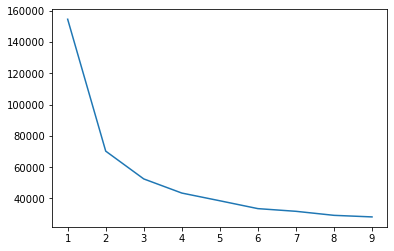

In [79]:
#Elbow method
plt.plot(df_cost['Cluster'], df_cost['Cost'])

### 6. Association Mining

The Association rule is a learning technique that helps identify the dependencies between two data items. Based on the dependency, it then maps accordingly so that it can be more profitable. Association rule furthermore looks for interesting associations among the variables of the dataset.

Association rules are created by thoroughly analyzing data and looking for frequent if/then patterns. Then, depending on the following two parameters, the important relationships are observed:

Support: Support indicates how frequently the if/then relationship appears in the database.

Confidence: Confidence tells about the number of times these relationships have been found to be true.

In [83]:
guns2

,Date,State,City/County,Kill Count,Injured Count,Gun Count,Handled_age_group,Handled_participant_type,Handled_gun_type,Handled_Stolen
54,2013-04-21,Washington,Federal Way,5,0,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen
95,2013-06-07,California,Santa Monica,6,1,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Not-stolen
207,2013-09-24,West Virginia,Huntington,0,6,2.0,Multiple_Age_Group,Victim & Suspect,Handgun,Stolen
1124,2014-01-07,Virginia,Ferrum,0,2,2.0,Adult,Victim & Suspect,Multiple_Weapons,Stolen
1136,2014-01-07,New Hampshire,Rochester,0,1,1.0,Adult,Victim & Suspect,Handgun,Not-stolen
...,...,...,...,...,...,...,...,...,...,...
239408,2018-03-29,Pennsylvania,Houston,0,0,1.0,Adult,Victim,Multiple_Weapons,Stolen
239423,2018-03-29,Ohio,Youngstown,0,0,1.0,Adult,Suspect,Multiple_Weapons,Stolen
239445,2018-03-30,Pennsylvania,Croydon,1,1,2.0,Multiple_Age_Group,Victim & Suspect,Multiple_Weapons,Stolen
239487,2018-03-30,North Carolina,Weldon,0,0,5.0,Adult,Suspect,Multiple_Weapons,Stolen


In [84]:
#Create dummy variables for categorical 
guns2 = pd.concat([guns2, pd.get_dummies(guns2['Handled_participant_type'], prefix='Participant=')], axis=1)
guns2 = pd.concat([guns2, pd.get_dummies(guns2['Handled_age_group'], prefix='Age=')], axis=1)
guns2 = pd.concat([guns2, pd.get_dummies(guns2['Handled_gun_type'], prefix='Gun=')], axis=1)
guns2 = pd.concat([guns2, pd.get_dummies(guns2['Handled_Stolen'], prefix='Gun_Status=')], axis=1)
guns2 = pd.concat([guns2, pd.get_dummies(guns2['City/County'], prefix='City/Count=')], axis=1)
guns2 = pd.concat([guns2, pd.get_dummies(guns2['Kill Count'], prefix='Kill Count=')], axis=1)
guns2 = pd.concat([guns2, pd.get_dummies(guns2['Injured Count'], prefix='Injured Count=')], axis=1)
guns2 = pd.concat([guns2, pd.get_dummies(guns2['Gun Count'], prefix='Gun Count=')], axis=1)
guns2 = pd.concat([guns2, pd.get_dummies(guns2['State'], prefix='State=')], axis=1)

In [85]:
#Drop columns 
guns2.drop('State', axis = 1, inplace = True)
guns2.drop('City/County', axis = 1, inplace = True)
guns2.drop('Handled_participant_type', axis = 1, inplace = True)
guns2.drop('Handled_age_group', axis = 1, inplace = True)
guns2.drop('Handled_gun_type', axis = 1, inplace = True)
guns2.drop('Handled_Stolen', axis = 1, inplace = True)

In [86]:
guns2.drop('Date', axis = 1, inplace = True)

In [87]:
guns2

,Kill Count,Injured Count,Gun Count,Participant=_Suspect,Participant=_Victim,Participant=_Victim & Suspect,Age=_Adult,Age=_Child,Age=_Multiple_Age_Group,Age=_Teen,...,State=_South Dakota,State=_Tennessee,State=_Texas,State=_Utah,State=_Vermont,State=_Virginia,State=_Washington,State=_West Virginia,State=_Wisconsin,State=_Wyoming
54,5,0,2.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
95,6,1,2.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
207,0,6,2.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1124,0,2,2.0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1136,0,1,1.0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239408,0,0,1.0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239423,0,0,1.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
239445,1,1,2.0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
239487,0,0,5.0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
guns3=guns2.iloc[:, 0:3]

In [89]:
guns2.drop(['Kill Count','Injured Count','Gun Count'], axis = 1, inplace = True)

In [90]:
guns2.replace(1, True, inplace = True)
guns2.replace(0, False, inplace = True)

In [91]:
guns4 = pd.concat([guns3, guns2], axis=1)

In [93]:
from mlxtend.frequent_patterns import apriori, association_rules

In [94]:
guns4 = pd.concat([guns4, pd.get_dummies(guns4['Kill Count'], prefix='Kill Count=')], axis=1)
guns4 = pd.concat([guns4, pd.get_dummies(guns4['Injured Count'], prefix='Injured Count=')], axis=1)
guns4 = pd.concat([guns4, pd.get_dummies(guns4['Gun Count'], prefix='Gun Count=')], axis=1)
guns4.drop('Kill Count', axis = 1, inplace = True)
guns4.drop('Injured Count', axis = 1, inplace = True)
guns4.drop('Gun Count', axis = 1, inplace = True)
guns4.replace(1, True, inplace = True)
guns4.replace(0, False, inplace = True)

In [122]:
# Building the model
frq_items_1 = apriori(guns4, min_support = 0.6, use_colnames = True)
 
# Collecting the inferred rules in a dataframe
rules_1 = association_rules(frq_items_1, metric ="lift", min_threshold = 1)
rules_1 = rules_1.sort_values(['lift','confidence'], ascending =[False, False])

In [123]:
rules_1

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
85,"(Gun_Status=_Stolen, Injured Count=_0, Kill Co...",(Participant=_Suspect),0.731669,0.742965,0.667459,0.912243,1.227841,0.123855,2.928933
96,(Participant=_Suspect),"(Gun_Status=_Stolen, Injured Count=_0, Kill Co...",0.742965,0.731669,0.667459,0.898373,1.227841,0.123855,2.640352
89,"(Gun_Status=_Stolen, Participant=_Suspect)","(Injured Count=_0, Kill Count=_0)",0.684701,0.809552,0.667459,0.974819,1.204146,0.113158,7.563189
92,"(Injured Count=_0, Kill Count=_0)","(Gun_Status=_Stolen, Participant=_Suspect)",0.809552,0.684701,0.667459,0.824480,1.204146,0.113158,1.796370
71,"(Age=_Adult, Injured Count=_0, Kill Count=_0)",(Participant=_Suspect),0.674792,0.742965,0.603052,0.893686,1.202864,0.101705,2.417694
...,...,...,...,...,...,...,...,...,...
52,"(Gun_Status=_Stolen, Injured Count=_0)",(Age=_Adult),0.766746,0.815101,0.630004,0.821659,1.008046,0.005029,1.036774
8,(Age=_Adult),(Kill Count=_0),0.815101,0.926675,0.760008,0.932409,1.006189,0.004674,1.084847
9,(Kill Count=_0),(Age=_Adult),0.926675,0.815101,0.760008,0.820145,1.006189,0.004674,1.028047
17,(Kill Count=_0),(Injured Count=_0),0.926675,0.871581,0.809552,0.873610,1.002327,0.001880,1.016049


In [97]:
strng_rules = rules_1[(rules_1['lift'] > 4) & (rules_1['confidence'] > 0.06) ]

In [98]:
strng_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1284,"(Gun Count=_1.0, Kill Count=_0, Participant=_V...",(Injured Count=_1),0.096314,0.115141,0.050337,0.522634,4.539088,0.039247,1.853628
1291,(Injured Count=_1),"(Gun Count=_1.0, Kill Count=_0, Participant=_V...",0.115141,0.096314,0.050337,0.437177,4.539088,0.039247,1.605632
298,(Injured Count=_1),"(Participant=_Victim & Suspect, Kill Count=_0)",0.115141,0.135355,0.068371,0.593804,4.387019,0.052786,2.128639
297,"(Participant=_Victim & Suspect, Kill Count=_0)",(Injured Count=_1),0.135355,0.115141,0.068371,0.505124,4.387019,0.052786,1.788044
1285,"(Injured Count=_1, Gun Count=_1.0)","(Participant=_Victim & Suspect, Kill Count=_0)",0.091359,0.135355,0.050337,0.550976,4.070608,0.037971,1.925611
1290,"(Participant=_Victim & Suspect, Kill Count=_0)","(Injured Count=_1, Gun Count=_1.0)",0.135355,0.091359,0.050337,0.371889,4.070608,0.037971,1.446623


In [99]:
#Consequents of apriori
rules_1['consequents'].value_counts()

(Kill Count=_0)                                                                                        175
(Age=_Adult)                                                                                           174
(Participant=_Suspect)                                                                                 173
(Injured Count=_0)                                                                                     166
(Gun_Status=_Stolen)                                                                                   165
                                                                                                      ... 
(Gun_Status=_Not-stolen, Age=_Adult, Injured Count=_0, Kill Count=_0)                                    1
(Age=_Adult, Injured Count=_0, Participant=_Victim & Suspect)                                            1
(Injured Count=_0, Kill Count=_0, State=_New York)                                                       1
(Gun_Status=_Stolen, Kill Count=_0, A

In [100]:
rules_1['SingularConsequent'] = rules_1['consequents'].apply(lambda x: True if len(x) == 1 else False)

In [101]:
rules_2 = rules_1[rules_1['SingularConsequent'] == True]
rules_2 = rules_2.sort_values(['lift','confidence'], ascending =[False, False])

In [102]:
rules_2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,SingularConsequent
1284,"(Gun Count=_1.0, Kill Count=_0, Participant=_V...",(Injured Count=_1),0.096314,0.115141,0.050337,0.522634,4.539088,0.039247,1.853628,True
297,"(Participant=_Victim & Suspect, Kill Count=_0)",(Injured Count=_1),0.135355,0.115141,0.068371,0.505124,4.387019,0.052786,1.788044,True
306,"(Gun Count=_1.0, Participant=_Victim & Suspect)",(Injured Count=_1),0.137337,0.115141,0.056282,0.409812,3.559231,0.040469,1.499285,True
24,(Injured Count=_1),(Participant=_Victim & Suspect),0.115141,0.190646,0.076893,0.667814,3.502900,0.054941,2.436449,True
25,(Participant=_Victim & Suspect),(Injured Count=_1),0.190646,0.115141,0.076893,0.403326,3.502900,0.054941,1.482987,True


In [103]:
#rules_interesting = rules_2[(rules_2['support'] > 0.1) & (rules_2['confidence'] > 0.8) & (rules_2['lift'] > 1.5) ]
rules_interesting = rules_2[(rules_2['support'] > 0.6) ]

In [104]:
rules_interesting.sort_values('support', ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,SingularConsequent
72,(Injured Count=_0),(Kill Count=_0),0.871581,0.926675,0.809552,0.928831,1.002327,0.001880,1.030304,True
73,(Kill Count=_0),(Injured Count=_0),0.926675,0.871581,0.809552,0.873610,1.002327,0.001880,1.016049,True
66,(Gun_Status=_Stolen),(Kill Count=_0),0.833532,0.926675,0.792113,0.950309,1.025505,0.019700,1.475630,True
67,(Kill Count=_0),(Gun_Status=_Stolen),0.926675,0.833532,0.792113,0.854790,1.025505,0.019700,1.146402,True
69,(Injured Count=_0),(Gun_Status=_Stolen),0.871581,0.833532,0.766746,0.879718,1.055411,0.040255,1.383986,True
68,(Gun_Status=_Stolen),(Injured Count=_0),0.833532,0.871581,0.766746,0.919876,1.055411,0.040255,1.602755,True
35,(Kill Count=_0),(Age=_Adult),0.926675,0.815101,0.760008,0.820145,1.006189,0.004674,1.028047,True
34,(Age=_Adult),(Kill Count=_0),0.815101,0.926675,0.760008,0.932409,1.006189,0.004674,1.084847,True
9,(Kill Count=_0),(Participant=_Suspect),0.926675,0.742965,0.733254,0.791275,1.065023,0.044768,1.231452,True
8,(Participant=_Suspect),(Kill Count=_0),0.742965,0.926675,0.733254,0.986930,1.065023,0.044768,5.610142,True
